In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# local
data_root_folder = "../data"
data_images_root_folder = "../data/images"

"""
# replaced by kaggle paths
data_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification"
data_images_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification/images/images"
"""

#/kaggle/input/rakuten-france-multimodal-product-classification/images
#/kaggle/input/rakuten-france-multimodal-product-classification/images/images/image_train

'\n# replaced by kaggle paths\ndata_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification"\ndata_images_root_folder = "/kaggle/input/rakuten-france-multimodal-product-classification/images/images"\n'

# Data exploration & preprocessing

In [2]:

X_train=pd.read_csv(f'{data_root_folder}/X_train_update.csv', index_col=0)
#X_test=pd.read_csv(f'{data_root_folder}/X_test_update.csv', index_col=0)
Y_train=pd.read_csv(f'{data_root_folder}/Y_train_CVw08PX.csv', index_col=0)
data=pd.concat([X_train,Y_train], axis=1 )
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


* Columns types are relevant
* Data size is relevant for Machine Learning
* For the suggested X_test, Y_test is missing, the test data will be generated from the train data 

## Missing & duplicated

35% of 'description' column values are missing & 60% of 'description' are distinct

### Missing images ?

In [ ]:
notfound=False
for index, row in data.iterrows():
    imgid = row['imageid']
    prdid = row['productid']
    try:
        mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
    except FileNotFoundError as error:  
       notfound=True
       print('Image not found', error)  
if not notfound:
    print('No image is missing')
    

### Duplicated values

In [3]:
def get_duplicated(data):
    data_descnotna=data[-data.description.isna()]
    data_desc_dup=data_descnotna[data_descnotna.duplicated(['description'])].groupby('description').agg(count=('prdtypecode', 'size'),prdtypecodes=('prdtypecode',lambda x: str(x.unique()))).sort_values(by=['count'], ascending=False).query('count>30')
    display(data_desc_dup)
    
get_duplicated(data)

,count,prdtypecodes
description,,
<br>Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres' n'apparaissent pas sur cette fiche produit c'est que l'éditeur ne nous les a pas fournies. Néanmoins dans la grande majorité de ces cas il n'existe ni langue ni sous titres en français sur ces imports.,251,[40]
Taille: En format A5 (144 cm x 21 cm) Caractéistique: -Excellente durabilité avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualitévous pouvez y érire facilement,231,[2522]
Taille: En format A5 (144 cm x 21 cm) Caracteristique: -Excellente durabilite avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualite: ecrire facilement sur et assez epaisse.,188,[2522]
Taille: En format A5 (144 cm x 21 cm) Caract?istique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit? ?rire facilement sur et assez ?aisse.,161,[2522]
Taille: En format A5 (144 cm x 21 cm) Caractéristique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit? écrire facilement sur et assez épaisse.,88,[2522]
<br />,80,[1940 2522 1301]
Piscine hors-sol en acier ronde Fidji de la marque Gré Indispensable pour passer des vacances entre amis dans la fraîcheur de l&#39;eau cette piscine en acier ronde Fidji vous offre un espace de nage et de jeux d&#39;eau pour tous les goûts. Conçue avec une structure en tôle laminée à froid et traitée par galvanisation la piscine hors-sol Gré vous assure une forte résistance dans le temps. Pour la baignade et le confort elle est habillée d&#39;un liner d&#39;une épaisseur de 30/100 traité anti-UV pour prévenir son vieillissement prématuré. La piscine hors-sol acier ronde Fidji est équipée d&#39;un système de filtration à sable (inclus) complet et d&#39;un skimmer pour vous garantir une eau claire et propre tout au long de la saison de baignade. Pour accéder facilement et en toute sécurité au bassin elle est livrée avec une échelle 2 x 3 marches. L&#39;équipement de la piscine en acier ronde Fidji : - Structure en acier avec margelles et poteaux verticaux - Système de filtration 3 m³/h vannes 5 voies cuve de Ø 30 cm 23 kg de sables (silex) puissance 125 W. - Liner en PVC bleu 30/100 - Skimmer - Échelle de sécurité 2 x 3 marches Les caractéristiques selon le modèle de piscine : Piscine ronde Fidji Ø 370 cm - Dimensions extérieures (Ø x h) : 370 x 122 cm - Dimensions intérieures (Ø x h) : Ø 350 x 120 cm - Volume d&#39;eau : 1010 m3 - Espace nécessaire (L x l) : 400 x 400 cm Piscine ronde Fidji Ø 480 cm - Dimensions extérieures (Ø x h) : Ø 480 x 122 cm - Dimensions intérieures (Ø x h) : Ø 460 x 120 cm - Volume d&#39;eau : 1745 m3 - Espace nécessaire (L x l) : 500 x 500 cm Piscine ronde Fidji Ø 570 cm - Dimensions extérieures (Ø x h) : Ø 570 x 122 cm - Dimensions intérieures (Ø x h) : Ø 550 X 120 cm - Volume d&#39;eau : 2494 m3 - Espace nécessaire (L x l) : 600 x 600 cm,56,[2583]
Kit de piscine hors-sol ronde en acier Bora Bora de la marque Gré Installez une piscine hors-sol dans le jardin et faites vous plaisir avec la fraîcheur de l&#39;eau pour des moments de détente avec vos proches. Ce kit de piscine est complet et vous permettra de profiter au plus vite de votre installation. La piscine hors-sol Bora Bora est vendue avec un équipement qui comprend :- une structure en acier galvanisé 45/100 avec margelles et poteaux- un liner 30/100 de couleur bleue en PVC- un épurateur à cartouche 38 m³/h puissance de 70 W- un skimmer de couleur blanche- et une échelle 2 x 3 marches. Le montage de la piscine hors-sol ronde en acier Bora Bora Gré est estimé à 2 h pour 2/3 personnes.Les différentes dimensions disponibles pour la piscine hors-sol Bora Bora :La piscine Bora Bora Ø 320 m- Dimensions extérieures (Ø x h) : 320 x 122 cm- Dimensions intérieures (Ø x h) : 300 x 120 cm- Volume d&#39;

- Most of duplicated values are related to one type, which sets a corrolation between that could be useful in predicting the label
- The duplicated value '\<br />' can be deleted as it doesn't bring any semantic
- The duplicated value '...Attention !!! Ce produit est un import si les informations 'langues' et 'sous-titres'...' can be deleted as well.

In [4]:
# replace all '...Attention !!' with empty string
exp = "<br>Attention !!! Ce produit est un import"
data['description'] = data['description'].apply(lambda x: '' if (exp in str(x)) else x)
exp = "<br />"
data['description'] = data['description'].apply(lambda x: '' if (str(x)==exp) else x)
get_duplicated(data)

,count,prdtypecodes
description,,
,332,[ 40 1940 2522 1301]
Taille: En format A5 (144 cm x 21 cm) Caractéistique: -Excellente durabilité avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualitévous pouvez y érire facilement,231,[2522]
Taille: En format A5 (144 cm x 21 cm) Caracteristique: -Excellente durabilite avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualite: ecrire facilement sur et assez epaisse.,188,[2522]
Taille: En format A5 (144 cm x 21 cm) Caract?istique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit? ?rire facilement sur et assez ?aisse.,161,[2522]
Taille: En format A5 (144 cm x 21 cm) Caractéristique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit? écrire facilement sur et assez épaisse.,88,[2522]
Piscine hors-sol en acier ronde Fidji de la marque Gré Indispensable pour passer des vacances entre amis dans la fraîcheur de l&#39;eau cette piscine en acier ronde Fidji vous offre un espace de nage et de jeux d&#39;eau pour tous les goûts. Conçue avec une structure en tôle laminée à froid et traitée par galvanisation la piscine hors-sol Gré vous assure une forte résistance dans le temps. Pour la baignade et le confort elle est habillée d&#39;un liner d&#39;une épaisseur de 30/100 traité anti-UV pour prévenir son vieillissement prématuré. La piscine hors-sol acier ronde Fidji est équipée d&#39;un système de filtration à sable (inclus) complet et d&#39;un skimmer pour vous garantir une eau claire et propre tout au long de la saison de baignade. Pour accéder facilement et en toute sécurité au bassin elle est livrée avec une échelle 2 x 3 marches. L&#39;équipement de la piscine en acier ronde Fidji : - Structure en acier avec margelles et poteaux verticaux - Système de filtration 3 m³/h vannes 5 voies cuve de Ø 30 cm 23 kg de sables (silex) puissance 125 W. - Liner en PVC bleu 30/100 - Skimmer - Échelle de sécurité 2 x 3 marches Les caractéristiques selon le modèle de piscine : Piscine ronde Fidji Ø 370 cm - Dimensions extérieures (Ø x h) : 370 x 122 cm - Dimensions intérieures (Ø x h) : Ø 350 x 120 cm - Volume d&#39;eau : 1010 m3 - Espace nécessaire (L x l) : 400 x 400 cm Piscine ronde Fidji Ø 480 cm - Dimensions extérieures (Ø x h) : Ø 480 x 122 cm - Dimensions intérieures (Ø x h) : Ø 460 x 120 cm - Volume d&#39;eau : 1745 m3 - Espace nécessaire (L x l) : 500 x 500 cm Piscine ronde Fidji Ø 570 cm - Dimensions extérieures (Ø x h) : Ø 570 x 122 cm - Dimensions intérieures (Ø x h) : Ø 550 X 120 cm - Volume d&#39;eau : 2494 m3 - Espace nécessaire (L x l) : 600 x 600 cm,56,[2583]
Kit de piscine hors-sol ronde en acier Bora Bora de la marque Gré Installez une piscine hors-sol dans le jardin et faites vous plaisir avec la fraîcheur de l&#39;eau pour des moments de détente avec vos proches. Ce kit de piscine est complet et vous permettra de profiter au plus vite de votre installation. La piscine hors-sol Bora Bora est vendue avec un équipement qui comprend :- une structure en acier galvanisé 45/100 avec margelles et poteaux- un liner 30/100 de couleur bleue en PVC- un épurateur à cartouche 38 m³/h puissance de 70 W- un skimmer de couleur blanche- et une échelle 2 x 3 marches. Le montage de la piscine hors-sol ronde en acier Bora Bora Gré est estimé à 2 h pour 2/3 personnes.Les différentes dimensions disponibles pour la piscine hors-sol Bora Bora :La piscine Bora Bora Ø 320 m- Dimensions extérieures (Ø x h) : 320 x 122 cm- Dimensions intérieures (Ø x h) : 300 x 120 cm- Volume d&#39;eau : 741 m3- Espace nécessaire (L x l) : 350 x 350 cmLa piscine Bora Bora Ø 370 m- Dimensions extérieures (Ø x h) : 370 x 122 cm- Dimensions intérieures (Ø x h) : 350 x 120 cm- Volume d&#39;eau : 1010 m3- Espace nécessaire (L x l) : 400 x 400 cmLa piscine Bora Bora Ø 480 m- Dimensions extérieures (Ø 

## Product types exploration

### Distribution

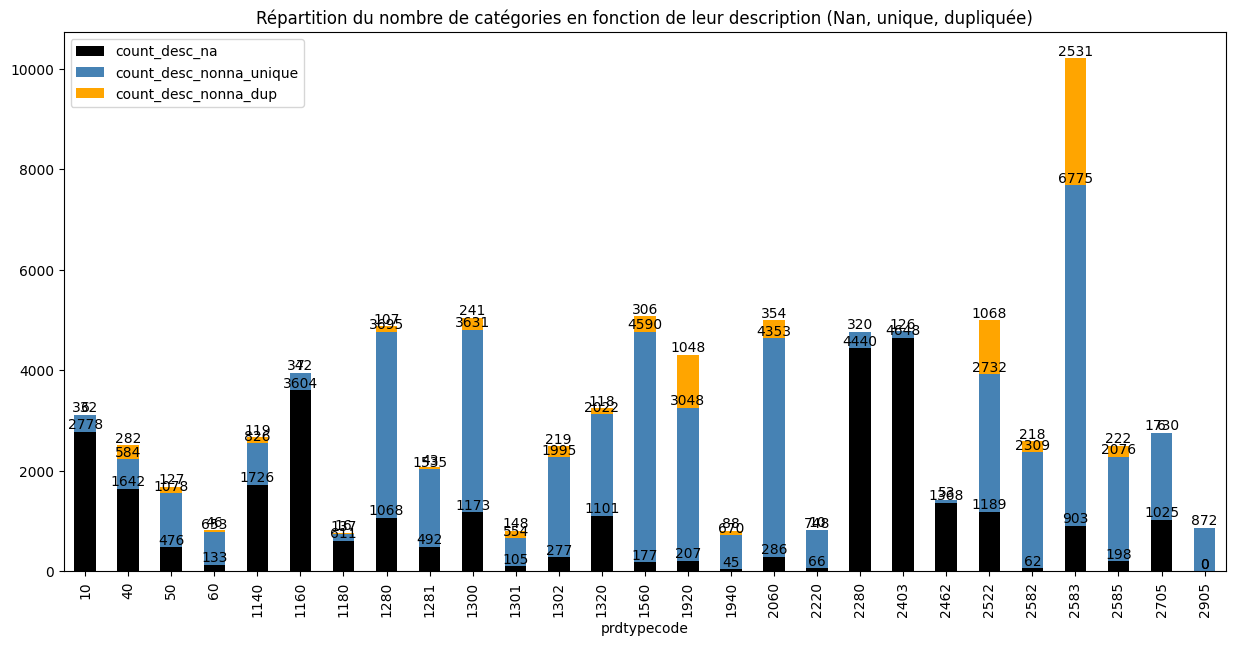

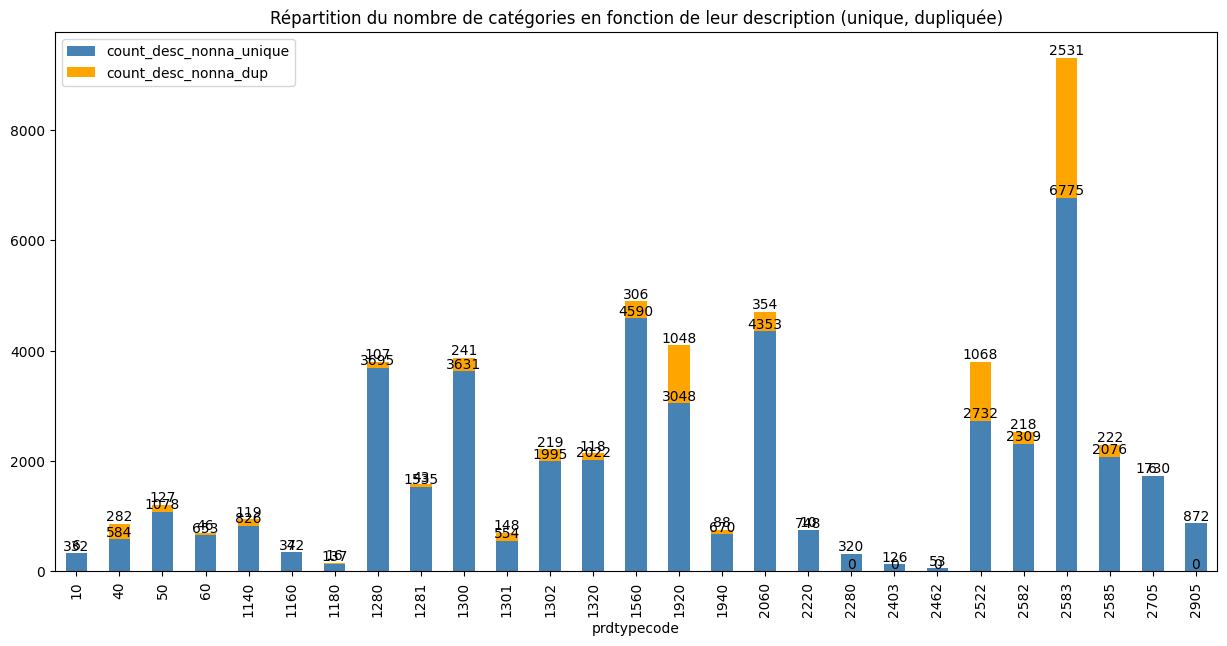

In [5]:

data_byprdtype_na=data.groupby('prdtypecode', group_keys=True).agg(
    count_desc_na=('description',lambda x: x.isna().sum()), 
    count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), 
    count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))

#display(data_byprdtype_na)

ax1=data_byprdtype_na.plot.bar(stacked=True, color=['black', 'steelblue', 'orange'], figsize=(15, 7))
ax1.bar_label(ax1.containers[0], labels=data_byprdtype_na['count_desc_na'])
ax1.bar_label(ax1.containers[1], labels=data_byprdtype_na['count_desc_nonna_unique'])
ax1.bar_label(ax1.containers[2], labels=data_byprdtype_na['count_desc_nonna_dup'])
plt.title("Répartition du nombre de catégories en fonction de leur description (Nan, unique, dupliquée)")

plt.show();

data_byprdtype_na_1=data.groupby('prdtypecode', group_keys=True).agg(
    count_desc_nonna_unique=('description',lambda x: (x[x.notna()].unique()).size), 
    count_desc_nonna_dup=('description',lambda x: x[x.notna()].duplicated().sum()))

ax2=data_byprdtype_na_1.plot.bar(stacked=True, color=['steelblue', 'orange'], figsize=(15, 7))
ax2.bar_label(ax2.containers[0], labels=data_byprdtype_na_1['count_desc_nonna_unique'])
ax2.bar_label(ax2.containers[1], labels=data_byprdtype_na_1['count_desc_nonna_dup'])
plt.title("Répartition du nombre de catégories en fonction de leur description (unique, dupliquée)")

plt.show();

- Product types are not evenly distributed, 2583 is an outlier 
- Need to rebalance the data, by : 
    * For types with highest counts, deleting rows with description = NA values & replacing duplicates
    * Some product types have small amount of relevant 'description', for those a strategy might be relying on the 'designation'
    * Then rebalance the rest following guidelines [here](https://medium.com/@dlikhitha99/all-methods-for-balancing-imbalanced-data-decfe1f4048d)




### Guess what's behind the product type code ?

The goal of following routine is to : 

* Identifiy to what extent the 'designation' & 'description' content are capable to relate to a product type
* What kind of data cleaning should be carried out to make text data the most relevant
* Determine the semantic behind the product type code by displaying random pictues and top keywords for each product type code, it would help in better human interpretation of results during the model experimentation.


In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
#from spacy.lang.en.stop_words import STOP_WORDS as en_stop
bytypecode = data.groupby('prdtypecode')
nsamples=10
max_features=20

print("---N of samples for each code:", str(nsamples), "---Max extracted features (words): ", str(max_features) , "---")
print("-----------------------------------------------------------------------------------------------------")

to_ignore = ['x', 'y', 'xy', 'cm','mm', 'm²', 'taille','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','blanc','gris','noir',
                          'le', 'la', 'les', 'un', 'deux', 'trois', 'quatre', 'cinq', 'une', 'et', 'de', 'du', 'des', 'ceci', 'cela', 'plusieurs', 'seul', 'seule', 'avec', 'pour', 
                           'ce', 'ceci', 'cela', 'ceux', 'celles', 'ne', 'non', 'par', 'pour', 'parce', 'que', 'qui', 'comment', 'comme', 'ou', 'où', 'tout', 
                          'toute', 'peut', 'être', 'li', 'ul', 'br', 'b', '<br />', 'x', 'p', 'div', 'h1', 'h2','h3','h4', 'td', 'tr', 'nbsp', 'amp', 
                          'cm', 'm', 'mm', 'm3', 'h', 'l', 'strong', 'ca','ainsi', 'cas', 'g', 'kg', 'gt', 'lt', 'eq', 'neq', 'let', 'neuf', 'quelqu', 
                          'oui', 'non', 'gb', 'mb', 'sans', 'dans', 'avec', 'plus', 'moins', 'vf',	'vo',	'yu']

from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
my_stopwords = set(STOPWORDS).union(to_ignore).union(stopwords.words('french')).union(stopwords.words('english')).union(stopwords.words('german'))

final_stopwords_list =  list(my_stopwords)  ### list(fr_stop) + list(en_stop) + list(my_stopwords)


coun_vect1 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)
coun_vect2 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features)
# used only for 'description'
coun_vect3 = CountVectorizer(lowercase=True, stop_words=final_stopwords_list, max_features=max_features) 

all_feaures = pd.DataFrame({'category_code': 0, 'words': [], 'words_count': 0 })
summary_df =  pd.DataFrame( { 'set_designation': [],  'n_designation': [],  
                   'set_description': [],  'n_description': [], 
                    'set_designation_description': [], 'n_designation_description': [], 
                    'set_intersection': [], 'n_set_intersection': [],
                      'set_intersection_1': [], 'n_set_intersection_1': [],
                            'set_intersection_2': [], 'n_set_intersection_2': []}
                          )
# define add to a list of DataFrames for code_words_count
code_words_count_dataframes = []
    

for code, frame in bytypecode:
    print(f"First {nsamples} entries for type {code!r}")
    fig, axs = plt.subplots(1, nsamples, figsize=(50, 30))
    frame_samples=frame.head(nsamples)
    display(frame_samples[['designation', 'description', 'prdtypecode']])
   
    for ax, (index, row) in zip(axs,frame_samples.iterrows()):
        imgid = row['imageid']
        prdid = row['productid']
        img = mpimg.imread(f'{data_images_root_folder}/image_train/image_{imgid}_product_{prdid}.jpg')
        
        imgplot = ax.imshow(img)
        ax.axis('off')
    plt.show()

    # Text count vectorizer on the product type data frame
    print('Before cleaning')
    count_matrix_desi = coun_vect1.fit_transform(frame['designation'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame['designation']+frame['description'].fillna(''))
    count_matrix_desc = coun_vect3.fit_transform(frame['description'].fillna(''))
    
    print(f'Top {max_features} features when designation', coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when description', coun_vect3.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', coun_vect2.get_feature_names_out())
   

    cols =['set_designation', 'n_designation', 
           'set_description', 'n_description', 
           'set_designation_description', 'n_designation_description', 
           'set_intersection', 'n_set_intersection',
          'set_intersection_1', 'n_set_intersection_1']
    print('After cleaning')
    
    frame_cleaned=frame.fillna('')\
        .replace(r'<.*?>','', regex=True)\
          .replace(r'\d+','', regex=True)\
            .replace(r'.*Attention !!! Ce produit est un import.*','', regex=True)\
            .replace(re.compile(r'\[Import Allemand\]'),'', regex=True)\
              #.replace({f'(?i){word}': '' for word in to_ignore}, regex=True)
    count_matrix_desi = coun_vect1.fit_transform(frame_cleaned['designation'])
    count_matrix_desc = coun_vect3.fit_transform(frame_cleaned['description'])
    count_matrix_desi_desc = coun_vect2.fit_transform(frame_cleaned['designation']+frame_cleaned['description'])
    
    set_1 = list(coun_vect1.get_feature_names_out())
    print(f'Top {max_features} features when designation', set_1)
    set_2 = list(coun_vect3.get_feature_names_out())
    print(f'Top {max_features} features when description', set_2)
    set_3 = list(coun_vect2.get_feature_names_out())
    print(f'Top {max_features} features when designation+description', set_3)
   
    # generate np.array for set_3 and write output to csv file (one by code)
    code_words_count = pd.DataFrame(data=count_matrix_desi_desc.toarray(),  columns=coun_vect2.get_feature_names_out())
    # add code column, leter we should add category description
    code_words_count['category_code'] = code
    # write to appropriate csv file
    code_words_count.to_csv('code_' + str(code) +'_words_count.csv')
    # append code_words_count code_words_count_dataframes list
    code_words_count_dataframes.append(code_words_count)
   
    # add new words list to all_feaures dataframe
    all_feaures.loc[len(all_feaures)] = [code, set_3, len(set_3)]
    
    
    print('======================================================================================================')
    n_designation = len(set_1)
    n_description = len(set_2)
    n_designation_description = len(set_3)
    
    set_intersection = list ( set(set_1) - set(set_2) )
    n_set_intersection = len(set_intersection)
    print("words found in 'designation' NOT in 'description':", n_set_intersection)
    display(set_intersection)
    
    if set_2 != []:
        set_intersection_1 = list ( set(set_2) - set(set_1) )
    else:
        set_intersection_1 = list ( set(set_1) )
    n_set_intersection_1 = len(set_intersection_1)
    print("words found in 'description' NOT in 'designation':", n_set_intersection_1)
    display(set_intersection_1)
    
    set_intersection_2 = list(set(set_1).intersection(set(set_2)))
    n_set_intersection_2 = len(set_intersection_2)
    print("words found in both 'description' AND 'designation':", n_set_intersection_2)
    display(set_intersection_2)
    
    
    # add on row to summary DF summary_df
    summary_df.loc[len(summary_df)] = [str(set_1), str(n_designation), 
                                       str(set_2), str(n_designation),
                                       str(set_3), str(n_designation_description), 
                                       str(set_intersection),str(n_set_intersection),
                                       str(set_intersection_1), str(n_set_intersection_1),
                                      str(set_intersection_2), str(n_set_intersection_2)]    
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('Sammary of differences:\n=================================') 
    print('all words by code:\n=================================') 
    print("n_designation : N of words in designation")
    print("n_description : N of words in description")
    print("n_designation_description : N of words in designation+description")
    print("set_intersection : Words in designation NOT in description")
    print("set_intersection : N of words in designation NOT in description")
    print("set_intersection_1 : Words in description NOT in designation")
    print("set_intersection_1 : N of words in description NOT in designation")
    print("set_intersection_2 : Words found in both 'description' AND 'designation")
    print("set_intersection_2 : N of words in both 'description' AND 'designation")
    
    display(summary_df)
    
    #all_feaures[len(all_feaures)] = ["", all_feaures['n_designation'].sum(), "", all_feaures['n_description'].sum(), 
    #                                 "", all_feaures['n_designation_description'].sum(),"", all_feaures['n_set_intersection'].sum(),
    #                                "", all_feaures['n_set_intersection_1'].sum(),
    #                                "", all_feaures['n_set_intersection_2'].sum()]
    display(all_feaures)
    all_feaures.to_csv('all_feaures.csv')

print("-----------------------------------------------------------------------")


Combining 'designation' with 'description' seems to give better results in term of identifying the features related to the product type  

Tokens that can be ignored:
* english and french stop words
* cm & mm
* markdown tags
* numerics

**Conclusions supplémentaires :** 
>1. Sur la base des métriques reportées sur le comptage des mots (designation vs description), il faut augmenter le # de tokens bien au-dela de 20, ce qui aura un impact sur les dimensions des matrices qui suivent...
>2. Des mots supplémentaires doivent être exclus en fonction des étapes précédentes. La liste des mots exclus peut être extériorisée dans un fichier texte séquentiel à alimenter...

>* Concatenate all generated DFs containing code + words (50 words by code) in one DataFrame 

In [6]:
print("Total des catégories =", len(code_words_count_dataframes))
if len(code_words_count_dataframes) > 0:
    sum_of_lines = 0
    for df in code_words_count_dataframes:
        sum_of_lines += df['category_code'].count()
    for df in code_words_count_dataframes:
        print('category code:', df['category_code'][0], "- shape (lines, words):", df.shape, "- % of all:", round(100*df.shape[0]/sum_of_lines, 0), "%")
    #    display(df.head())
#print("------------------------------")
print("total des lignes de category_code :", sum_of_lines)

Total des catégories = 27
category code: 10 - shape (lines, words): (3116, 21) - % of all: 4.0 %
category code: 40 - shape (lines, words): (2508, 21) - % of all: 3.0 %
category code: 50 - shape (lines, words): (1681, 21) - % of all: 2.0 %
category code: 60 - shape (lines, words): (832, 21) - % of all: 1.0 %
category code: 1140 - shape (lines, words): (2671, 21) - % of all: 3.0 %
category code: 1160 - shape (lines, words): (3953, 21) - % of all: 5.0 %
category code: 1180 - shape (lines, words): (764, 21) - % of all: 1.0 %
category code: 1280 - shape (lines, words): (4870, 21) - % of all: 6.0 %
category code: 1281 - shape (lines, words): (2070, 21) - % of all: 2.0 %
category code: 1300 - shape (lines, words): (5045, 21) - % of all: 6.0 %
category code: 1301 - shape (lines, words): (807, 21) - % of all: 1.0 %
category code: 1302 - shape (lines, words): (2491, 21) - % of all: 3.0 %
category code: 1320 - shape (lines, words): (3241, 21) - % of all: 4.0 %
category code: 1560 - shape (lines, 

In [14]:
from functools import reduce

words_dataframes = code_words_count_dataframes

# STEP 1 : concatiner l'ensemble des samples en cumulant les "words" et en mettant 0 pour les catégries ne contenant pas mes mots associés
if len(words_dataframes) > 0:
    list_of_all_words = []
    
    for df in words_dataframes:
        list_of_all_words.extend(list(df.columns[0:-1])) # exclure category_code
    
    #display(list_of_all_words)
    
#df_target = pd.DataFrame(data= list([]), columns= ['category_code']) 
list_of_all_words.insert(0, 'category_code') 
print("list_of_all_words ", len(list_of_all_words), list_of_all_words)
#df_target = pd.DataFrame(data= list([]), columns= list_of_all_words )  
df_target = pd.DataFrame(data= list([]), columns= ['category_code'] )   
#df_target.reset_index()
    
display("df_target.columns:", df_target.columns)
display("df_target.head():", df_target.head())


# insert all category_code as one column
categories = [pd.DataFrame()]
for df in words_dataframes:
    categories.append( pd.DataFrame (df['category_code']) )
df_target = pd.concat(categories, axis=0).reset_index(drop=True)
display('df_target afer concatinating category_code:', df_target)


print("BEFORE merge\n------------------")
print("df_target.shape=", df_target.shape)
display(df_target.head())
display(df_target.tail())

# df_target.to_csv(f'{data_root_folder}/vectorizations/df_target.csv')


# insérer le reste en fonction des valeurs "category_code" en utilisant le merge
# réf;(thanks): https://stackoverflow.com/questions/44327999/how-to-merge-multiple-dataframes
df_target = reduce(lambda  left,right: pd.merge(left,right,on=['category_code'],
                                            how='outer', suffixes=('', '_x')), words_dataframes).fillna(0)


print("AFTER merge\n------------------")
print("df_target.shape=", df_target.shape)
display(df_target.head())
display(df_target.tail())

# write to csv file
print("writting to CSV file", f'{data_root_folder}/words_count_dataset.csv', ...)
df_target.to_csv(f'{data_root_folder}/vectorizations/words_count_dataset.csv')


list_of_all_words  541 ['category_code', 'ammareal', 'année', 'book', 'caritatives', 'chez', 'collection', 'donnons', 'edition', 'etat', 'guide', 'histoire', 'livre', 'occasion', 'organisations', 'partenaires', 'prix', 'tome', 'vendons', 'vie', 'édition', 'audio', 'boutons', 'console', 'contrôleur', 'câble', 'edition', 'facile', 'forfait', 'haute', 'jeu', 'jeux', 'matériel', 'nintendo', 'pc', 'pièce', 'plastique', 'ps', 'spécification', 'version', 'xbox', 'batterie', 'charge', 'compatible', 'console', 'contrôleur', 'câble', 'facile', 'haute', 'jeu', 'jeux', 'manette', 'nintendo', 'produit', 'protection', 'ps', 'silicone', 'support', 'switch', 'usb', 'xbox', 'console', 'denuméro', 'game', 'intégré', 'jeu', 'jeux', 'lecteur', 'marque', 'mini', 'modèle', 'ouicommunication', 'ouiecran', 'poche', 'portable', 'pouces', 'rétro', 'tactile', 'tv', 'vidéo', 'écran', 'collection', 'eacute', 'emballage', 'env', 'figure', 'figurine', 'figurines', 'funko', 'haute', 'licence', 'marvel', 'officielle',

'df_target.columns:'

Index(['category_code'], dtype='object')

'df_target.head():'

,category_code


'df_target afer concatinating category_code:'

,category_code
0,10
1,10
2,10
3,10
4,10
...,...
84911,2905
84912,2905
84913,2905
84914,2905


BEFORE merge
------------------
df_target.shape= (84916, 1)


,category_code
0,10
1,10
2,10
3,10
4,10


,category_code
84911,2905
84912,2905
84913,2905
84914,2905
84915,2905


AFTER merge
------------------
df_target.shape= (84916, 541)


,ammareal,année,book,caritatives,chez,collection,donnons,edition,etat,guide,...,hd,intel,internet,jeu_x,nvidia,processeur,radeon,requise,système,windows
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ammareal,année,book,caritatives,chez,collection,donnons,edition,etat,guide,...,hd,intel,internet,jeu_x,nvidia,processeur,radeon,requise,système,windows
84911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,9.0,1.0,1.0,1.0,2.0,1.0,2.0
84912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,1.0,0.0,1.0,1.0,2.0
84913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0
84914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0


writting to CSV file ../data/words_count_dataset.csv Ellipsis


In [15]:
# On voit bien qu'il y un désiquilbre entre les 'category_code' en termes de nbre de lignes reportant les mots résultat de la vectorization
# afin d'équilibrer les dataset d'entrainement et de test, on peut appliquer les méthode traitant l'oversampling ou undersampling   
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score


words_dataframes = code_words_count_dataframes

# STEP 1 : concatiner l'ensemble des samples en cumulant les "words" et en mettant 0 pour les catégries ne contenant pas mes mots associés
if len(words_dataframes) > 0:
    list_of_all_words = []
    
    for df in words_dataframes:
        list_of_all_words.extend(list(df.columns[0:-1])) # exclure category_code
    
    # get sequentialy 2 by 2 common words between dataframes
    # on doit le faire 2 par 2 mais pour tous les codes
    print("Common words:\n")
    last_df = None
    for df in words_dataframes:
        if last_df is not None:
            intersection = set(list(df.columns[0:-1])).intersection(set(last_df.columns[0:-1]))
            if len(intersection)>0:
                print("codes catégorie=", df[df.columns[-1]][0], "et",  last_df[last_df.columns[-1]][0])
                print('intersection:', intersection , "found in :")
                print(df.columns[0:-1])
                print(last_df.columns[0:-1])  
                print("================================================================================================")   
        last_df = df
    
    # NOTE : utiliser mangle_dupe_cols=True pour accepter d'avoir plusieurs mots identiques dans le dataset cible en cas de lecture d'un CSV par exemple   
    # https://stackoverflow.com/questions/39986925/multiple-columns-with-the-same-name-in-pandas
    


Common words:

codes catégorie= 40 et 10
intersection: {'edition'} found in :
Index(['audio', 'boutons', 'console', 'contrôleur', 'câble', 'edition',
       'facile', 'forfait', 'haute', 'jeu', 'jeux', 'matériel', 'nintendo',
       'pc', 'pièce', 'plastique', 'ps', 'spécification', 'version', 'xbox'],
      dtype='object')
Index(['ammareal', 'année', 'book', 'caritatives', 'chez', 'collection',
       'donnons', 'edition', 'etat', 'guide', 'histoire', 'livre', 'occasion',
       'organisations', 'partenaires', 'prix', 'tome', 'vendons', 'vie',
       'édition'],
      dtype='object')
codes catégorie= 50 et 40
intersection: {'facile', 'nintendo', 'jeu', 'jeux', 'xbox', 'contrôleur', 'haute', 'ps', 'console', 'câble'} found in :
Index(['batterie', 'charge', 'compatible', 'console', 'contrôleur', 'câble',
       'facile', 'haute', 'jeu', 'jeux', 'manette', 'nintendo', 'produit',
       'protection', 'ps', 'silicone', 'support', 'switch', 'usb', 'xbox'],
      dtype='object')
Index(['audi

From the data assessment above & search made in rakuten website, following product types labels are identified as related to the existing product type codes.

In [23]:
map_prdtypecode_guess={10:'Livres/Livres anciens ?', 
                       40:'Jeux vidéo', 
                       50:'Jeux vidéo/Accessoires', 
                       60:'Consoles', 
                       1140:'Goodies/Figurines', 
                       1160:'Goodies/Cartes de jeux', 
                       1180:'Jouets enfant/occasion ?',
                       1280:'Jouets enfant',
                       1281:'Jouets enfant/occasion ?',
                       1300: 'Modélisme',
                       1301: 'Puériculture',
                       1302: 'Puériculture autre ?',
                       1320: 'Puériculture autre ?',
                       1560: 'Mobilier',
                       1920: 'Coussin Décoratif',
                       1940: 'Alimentation',
                       2060: 'Décoration',
                       2220: 'Aminalerie',
                       2280: 'Revues et magazines anciens',
                       2403: 'Lots de Livres et de Revues',
                       2462: 'Lots de consoles et jeux vidéo',
                       2522: 'Fournitures Papeterie',
                       2582: 'Mobilier de Jardin',
                       2583: 'Entretien piscine & spa',
                       2585: 'Outillage de jardin',
                       2705: 'Livres/Littérature',
                       2905: 'Jeux Vidéo/PC'}
data_prdtypecode_label_guess =pd.DataFrame.from_dict(map_prdtypecode_guess, orient = 'index', columns=['prdtypelabelguess'])


## Text data preprocessing

In [17]:
to_ignore=['cm','mm','taille','dimensions','hauteur','largeur','couleur','nbsp','comprend','description','import','france','japonais','anglais','blanc','gris','noir']
data_cleaned=data\
  .fillna('')\
        .replace(r'<.*?>','', regex=True)\
          .replace(r'\d+','', regex=True)\
            .replace(r'.*Attention !!! Ce produit est un import.*','', regex=True)\
            .replace(re.compile(r'\[Import Allemand\]'),'', regex=True)\
              .replace({f'(?i){word}': '' for word in to_ignore}, regex=True)

data_cleaned["desi_desc"] = data_cleaned["designation"].str.cat(data_cleaned["description"], sep = " ")
data_cleaned.drop(['designation','description'], axis=1, inplace=True)

In [9]:
display(data_cleaned)

,productid,imageid,prdtypecode,desi_desc
0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / Seiten /...
1,436067568,1008141237,2280,Journal Des Arts (Le) N° Du // - L'art Et Son...
2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland (Marionn...
4,278535884,1077757786,2705,La Guerre Des Tuques Luc a des id&eacute;es de...
...,...,...,...,...
84911,206719094,941495734,40,The Sims [ ]
84912,3065095706,1188462883,2583,Kit piscine acier NEVADA déco pierre Ø .m x .m...
84913,440707564,1009325617,2280,Journal Officiel De La Republique Francaise N°...
84914,3942400296,1267353403,1560,Table Basse Bois De Récupération Massif Base h...


In [18]:
data_cleaned_with_prdtypelabel_guess=pd.merge(left=data_cleaned, left_on='prdtypecode', right=data_prdtypecode_label_guess, right_index=True )
display(data_cleaned_with_prdtypelabel_guess)

,productid,imageid,prdtypecode,desi_desc,prdtypelabelguess
0,3804725264,1263597046,10,Olivia: Personalisiertes Notizbuch / Seiten /...,Livres/Livres anciens ?
1,436067568,1008141237,2280,Journal Des Arts (Le) N° Du // - L'art Et Son...,Revues et magazines anciens
2,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,Jeux vidéo/Accessoires
3,50418756,457047496,1280,Peluche Donald - Europe - Disneyland (Marionn...,Jouets enfant
4,278535884,1077757786,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,Livres/Littérature
...,...,...,...,...,...
84911,206719094,941495734,40,The Sims [ ],Jeux vidéo
84912,3065095706,1188462883,2583,Kit piscine acier NEVADA déco pierre Ø .m x .m...,Entretien piscine & spa
84913,440707564,1009325617,2280,Journal Officiel De La Republique Francaise N°...,Revues et magazines anciens
84914,3942400296,1267353403,1560,Table Basse Bois De Récupération Massif Base h...,Mobilier


## Text data exploration

<Axes: >

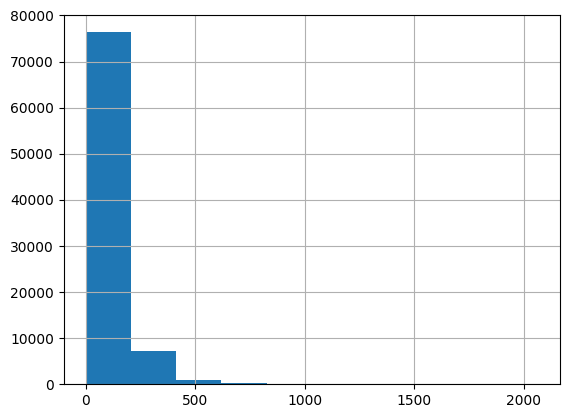

In [19]:
data_cleaned['desi_desc'].str.split().map(lambda x: len(x)).hist()

'designation' range from 10 to 250 characters and generally, it is between 75 to 100 characters

<Axes: >

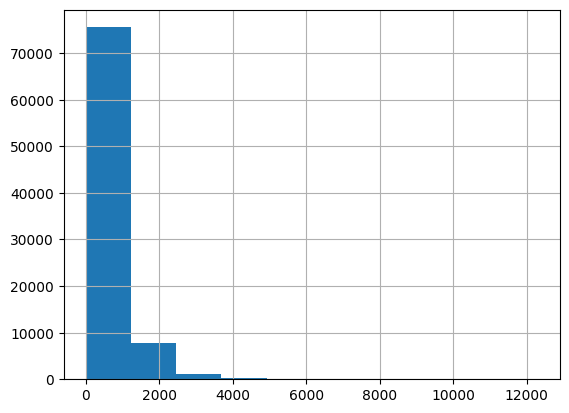

In [20]:
data_cleaned['desi_desc'].str.len().hist()

Number of words in designation ranges from 3 to 50 and mostly falls between 3 to 18 words.

<Axes: >

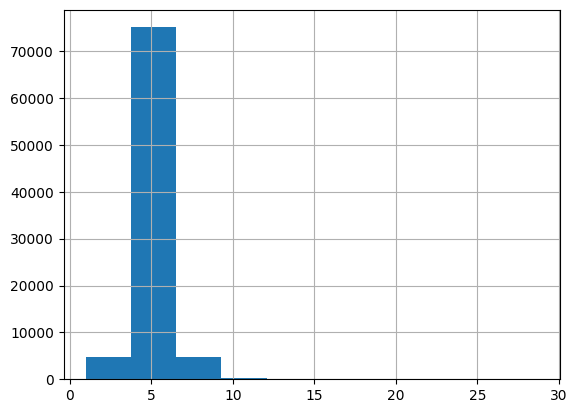

In [13]:
data_cleaned['desi_desc'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

The average word length ranges between 2 to 8 with 5 being the most common length